# Study of Exploration Algorithms in developmental robotics with Explauto

This tutorial explains and implements some exploration algorithms in developmental robotics.  
The goal is to get used to the concepts of Goal Babbling, Active Learning based on learning progress and Model Babbling, by experimenting with those strategies in simple environments composed of a robotic arm interacting with objects.  
We use the [Explauto](https://github.com/flowersteam/explauto) Python library as a toolkit to help implement exploration algorithms.

The progression is the following:

    I.   Exploring by hand the movements of a robotic arm
    II.  Random Motor Babbling
    III. Random Goal Babbling
    IV.  Active Goal Babbling
    V.   More complex environment
    VI.  Active Model Babbling

### Requirements:

- Python 2.7, Numpy, Scipy >= 0.16, Scikit-learn, [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html). For users not familiar with Python, installing [Anaconda](https://www.continuum.io/downloads) for Python 2.7 includes all of them.
- [Explauto](https://github.com/flowersteam/explauto), the Python Library for Autonomous Exploration. See [installation](http://flowersteam.github.io/explauto/installation.html) section: the simplest is to install explauto via pip: 'pip install explauto'.

You might need to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension' to enable the interaction with sliders in part I.


To run this notebook, run the following command in the ExplorationAlgorithm folder:

    jupyter notebook main.ipynb
    
    
Let's begin with the import of all the classes and functions we will need in this notebook.

In [1]:
import matplotlib
matplotlib.use('TkAgg')

from utils import *

-------------------------------
#  I. Exploring by hand the movements of a robotic arm

This first part is designed to have a first experience of the complexity of the task given to the robot, by the exploration of the motor parameters by hand.

The 3 joints of the robotic arm are controlled through DMPs with 3 basis functions, which results in 9 motor parameters in total that produce a movement of the arm. You can control those parameters by hand through the 9 following sliders (move the sliders and then hit "Run" button).

Try to catch the ball !

In [2]:
# Had to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension'
fig, ax = plt.subplots()

environment1 = ArmBall()

def movement(m1=0., m2=0., m3=0., m4=0., m5=0., m6=0., m7=0., m8=0., m9=0.):
    environment1.update(array([m1, m2, m3, m4, m5, m6, m7, m8, m9]))
    display_movement(fig, ax, environment1)
    
interact_manual(movement, m1=(-1., 1., 0.01), m2=(-1., 1., 0.01), m3=(-1., 1., 0.01), 
                          m4=(-1., 1., 0.01), m5=(-1., 1., 0.01), m6=(-1., 1., 0.01), 
                          m7=(-1., 1., 0.01), m8=(-1., 1., 0.01), m9=(-1., 1., 0.01))


<function __main__.movement>

-------------------------------
#  II. Random Motor Babbling

Now, let's use a higher dimensional arm (e.g. 7 joints and 3 DMP basis per joint so 21 motor parameters in total).  
You can play with those parameters in the following block.  

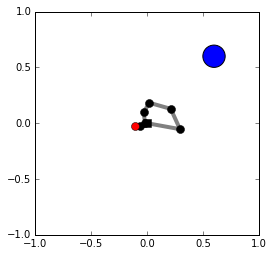

In [2]:
# Parameters to change:
n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint

# Definition of the environment with number of joints and DMP basis per joint
environment2 = ArmBall(n_joints, n_dmp_basis)

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1., 1.))
ax.set_ylim((-1., 1.))

# Plot a random position of the arm
environment2.env.update(environment2.env.random_motors()[0])
environment2.env.plot(ax, 0)

We first implement the Random Motor Babbling strategy, where the robot explores the dynamics of its arm by just trying random motor configurations.

In the following, we do 1000 iterations of Random Motor Babbling and for each iteration, if the ball was caught by the arm, we plot the trajectory of the ball (with a curve) and its last position (ball).

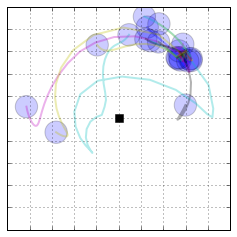

In [5]:
# Parameters to change:
iterations = 2000 # Number of iterations

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1., 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_mb = []


for _ in range(iterations):
    m = environment2.random_motor() # sample a random motor command m
    s = environment2.update(m) # observe the sensory effect s=(x, y): the last position of the ball
    if abs(s[-1] - 0.6) > 0.001: # if the ball has been moved by the arm, we plot its trajectory and last position
        explored_s_mb += [s] # store s for later evaluation
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.3)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))
        
plt.xticks(linspace(-1., 1., grid_size + 1))
plt.yticks(linspace(-1., 1., grid_size + 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()

### Exploration measure
We compute the number of cells in the above grid where the ball has been placed at the end of the different movements.

In [6]:
print "Number of ball catch:", len(explored_s_mb)
print "Measure of exploration:", int(compute_explo(array(explored_s_mb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

Number of ball catch: 21
Measure of exploration: 10


Using 7 joints and 3 DMP basis per joint, we can see that the ball has been caught only a few times and that a small number of cells have been reached with the ball.  
If we increase the number of joints, it becomes even harder to randomly grab the ball.  
If we increase the number of DMP basis, the movement lasts longer and has more chances to grab the ball.

-------------------------------
#  III. Random Goal Babbling

Goal babbling consists in choosing goals in the sensory space and using the current state of the model of the environment (the sensorimotor model) to infer a motor action supposed to reach the goals (inverse prediction). The robot then executes the command through the environment and observes the actual sensory effect. The sensorimotor model is finally updated according to this experience.

In the Explauto library, there are different algorithms available to perform inverse prediction from the database of sensorimotor experience.  
Here we will use the Nearest Neighbor algorithm. This sensorimotor model simply stores sensorimotor experience, ie. (m,s)
pairs where m are motor commands (here arm joint positions) and s are the corresponding sensory effects (here ball end positions).  
When asked for an inverse prediction to reach a sensory goal s, it returns the motor command m associated to the nearest neighbor of s in the stored sensory experience, and adds some exploration noise (gaussian with standard deviation 'sigma_explo_ratio').


In Random Goal Babbling, the goals are choosen randomly in the sensory space, thus the bounds of the space are important.  
Here the arm can reach the circle of radius 1, and we define the sensory space as the square of size 10, meaning that a lot of this space is unreachable. When the robot chooses an unreachable goal, it will explore around the closest reached points.

Number of ball catch: 767
Measure of exploration: 29


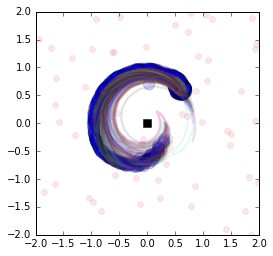

In [14]:
# Parameters to change:
iterations = 2000 # Number of iterations
n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint
goal_size = 10.   # Size of the 2D goal space
sigma_explo_ratio = 0.05 # Exploration noise (standard deviation)

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2., 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
goals_s_gb = []
explored_s_gb = []

# Definition of the environment
environment2 = ArmBall(n_joints, n_dmp_basis, goal_size)

# Initialization of the sensorimotor model
sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')

# Bootstrap sensorimotor model: 1 random motor babbling
m = environment2.random_motor()
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(iterations):
    if (not sm_model.bootstrapped_s) or (random() < 0.2): 
        # Do random motor babbling while the ball has not been grasped, and then in 20% of the trials
        m = environment2.random_motor()
    else:
        # Sample a random goal in the sensory space:
        s_goal = rand_bounds(environment2.conf.s_bounds)[0]
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # Add exploration noise (of variance sigma) to experiment new motor parameters:
        m = normal(m, sigma_explo_ratio)
        # Plot the goal in red:
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)
        goals_s_gb += [s_goal]
        
    s = environment2.update(m) # observe the sensory effect s=(x, y): the last position of the ball
    sm_model.update(m, s) # update sensorimotor model
    
    if abs(s[-1] - 0.6) > 0.001: # if the ball has been moved by the arm, we plot its trajectory and last position
        explored_s_gb += [s] # store s for later evaluation
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))
        
        
print "Number of ball catch:", len(explored_s_gb)
print "Measure of exploration:", int(compute_explo(array(explored_s_gb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

The previous figure is zoomed in to better see the reachable part of the sensory space.

Random Goal Babbling allows a more efficient covering of the reachable sensory space than with the motor babbling strategy (when the agent samples directly in the motor space).

In the next plot, we zoom out to plot the entire sensory space (of size goal_size).

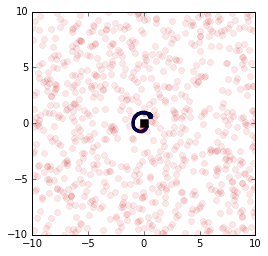

In [15]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-goal_size, goal_size))
ax.set_ylim((-goal_size, goal_size))
ax.plot(0., 0., 'sk', ms=8)

for s_goal, s in zip(goals_s_gb, explored_s_gb): 
    ax.add_patch(Circle(tuple(s), 0.1, fc="b", alpha=0.2))
    ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)

-------------------------------
# IV. Active Goal Babbling

In the previous experiment, we have seen that the goals are randomly sampled in the goal space, even if only a small part of this space is reachable.  
The agent could monitor how well it is achieving its goals and try to give itself goals that are reachable, but also not too easy.  

We call this strategy Active Learning.  
In order to monitor its performance on different goals, the goal space is discretized into small cells.  
For each goal in a cell, the agent computes the error (distance between goal and reached point) to reach the goal.
If the reached point is not in the same cell as the goal, then the error is considered maximal.
Then, the derivative of this errors gives a measure of progress in each cell.  

Here is the computation of the interest of a cell given the 20 (window size ws=20) last distance error in this cell (from $cell.error_1$ to $cell.error_{ws}$):

$Interest~(cell) = \Big| \frac{1}{ws/2}{\Large \Sigma}_{i=0}^{i=ws/2}~cell.error_i - \frac{1}{ws/2}{\Large \Sigma}_{i=ws/2+1}^{i=ws/2}~cell.error_i \Big|$

The newly reached cells also get a novelty bonus to be explored for $ws$ iterations.  
This implementation is an adapted version of the [SAGG-RIAC](https://hal.inria.fr/hal-00788440/document) algorithm, with a fixed discretization of the sensory space, and a modification of the computation of the progress.

For instance, if the goals in a cell are unreachable, then the error is always maximal in that cell, and the progress is 0.  
Also, if the cell is reachable and already well explored, then the error is always low, and the progress is low.  
However, if the error decreases in a given cell, that means the agent is making progress to reach its goals, so the progress is high.  
The interest is defined as the absolute value of the progress, so that if the error increases (for instance if a ball has changed its behavior so the sensorimotor model has to be re-explored in some cells), then the progress is negative but the interest is positive.

Given this measure of progress (or interest), the agent chooses at each iteration a cell where the progress is high (but also explores random cells with a small probability), and then a random goal in this cell.

In the Explauto framework, the class 'DiscretizedProgress' already implements this algorithm, and the object monitoring the progress is called an 'Interest Model'. We will use the methods 'sample' to pick a cell and a random point in the cell, and 'update' to give back the information about the reached point so that error and progress can be computed.


Number of ball catch: 702
Measure of exploration: 55


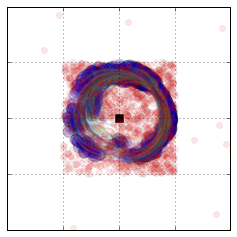

In [12]:
# Parameters to change:
iterations = 2000 # Number of iterations
n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint
goal_size = 10.   # Size of the 2D goal space
sigma_explo_ratio = 0.05 # Exploration noise (standard deviation)


fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb = []


# Definition of the environment
environment2 = ArmBall(n_joints, n_dmp_basis, goal_size)

# Initialization of the sensorimotor model
sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')

# Initialization of the interest model
im_model = DiscretizedProgress(environment2.conf, environment2.conf.s_dims, 
                               **{'x_card': 20*20,   # 20 is the number of cells on each dimension
                                  'win_size': 20,    # window size parameter (ws)
                                  'eps_random': 0.2, # proportion of random choice of cell
                                  'measure': competence_dist})

# Bootstrap model: 1 random motor babbling
m = environment2.random_motor()
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(iterations):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        # Do random motor babbling while the ball has not been grasped, and then in 20% of the trials
        m = environment2.random_motor()
        s = environment2.update(m)
        sm_model.update(m, s)
    else:
        # Sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # Add exploration noise (of variance sigma) to experiment new motor parameters:
        m = normal(m, sigma_explo_ratio)
        # Execute this command and observe the corresponding sensory effect:
        s = environment2.update(m)
        # Update the sensorimotor model:
        sm_model.update(m, s)
        # Update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        # Plot the goals in red:
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)
        
    if abs(s[-1] - 0.6) > 0.001: # if the ball has been moved by the arm, we plot its trajectory and last position
        explored_s_agb += [s] # store s for later evaluation
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))


plt.xticks(linspace(-2., 2., 5))
plt.yticks(linspace(-2., 2., 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()
        
print "Number of ball catch:", len(explored_s_agb)
print "Measure of exploration:", int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

The previous figure is zoomed in and shows only 16 of the 400 interest cells.

We can see here that the goals are not sampled uniformly in the bounds but in small cells, depending on their progress.

Let's plot a snapshot of the current progress (at iteration 2000) in each cell of the discretization.  
The 2D space of the next plot is of size 'goal_size=10.', so the region of radius 1 that the arm can cover is small, in the middle.

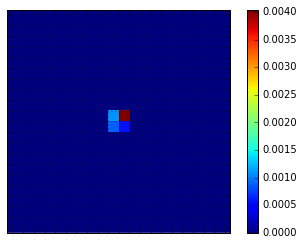

In [16]:
progress_flat = abs(im_model.discrete_progress.progress())
progress_array = zeros(im_model.space.cardinalities)

for idx in range(len(progress_flat)):
    progress_array[im_model.space.index2multi(idx)] = progress_flat[idx]

fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])
cax = ax.imshow(transpose(progress_array), origin='lower', cmap=cm.jet, interpolation="none")
fig.colorbar(cax)
plt.xticks(linspace(0., 19., 21))
plt.yticks(linspace(0., 19., 21))
ax.grid()


The progress is 0 in unreachable cells, and can be high in reached cells, in the middle.

-------------------------------
# V. More complex environment

In the previous environments, the exploration of the sensory variables lead to interesting learning, but in more realistic environments that might not be the case. We define here a similar environment with objects that are not interesting to interact with, either because they are too easy to learn, or because they are not learnable.

The environment is composed of the same arm with 21 parameters plus a stick that can be used as a tool to move a blue ball (the ball can't be grasped by the hand anymore). 
We also add a static magenta ball that can't be move in any way, and 2 random balls that do a random walk.

The motor space is the same as before (21D), and the sensory space is composed of the trajectories of each item: the arm, the tool and the 3 balls.  
There are 6 dimensions for each item (so 36D), representing the 2D position of the item at 3 time points along the movement duration.

In [1]:
# !! BEFORE RUNNING THIS CELL, RESTART KERNEL NOW to recover TkAgg backend
import matplotlib
matplotlib.use('TkAgg')
from utils import *

In [2]:
# Pop a separate window
fig, ax = plt.subplots()

In [17]:
# Definition of the environment
environment3 = ArmStickBalls(n_joints=7,            # Number of joints
                             n_dmp_basis=3,         # Number of basis per joint
                             goal_size=2.,          # Size of goal space
                             stick_handle_tol=0.05, # Maximal distance to grab the stick with the hand
                             stick_length=0.30,     # Stick length, 
                             ball_size=0.10,        # Maximal distance to grab the ball with the stick
                             random_ball_noise=0.20 # Random balls Gaussian noise amplitude 
                             )

In the following, we display 1 random movement of the arm (but you can run it again and again), and 1 movement tuned to reach the tool and move the blue ball with the tool (as a video). 
The probability of getting the tool and moving the blue ball with a random movement (in 21D) is around 1 out of 10000.

You can also change the parameters of the environment and try motor babbling again.

In [4]:
# 1 iteration of Random Motor Babbling
m = environment3.random_motor()
s = environment3.update(m)
display_movement(fig, ax, environment3, time_step=0.1)

In the next block, we plot random motor parameters and the associated sensory feedback in a bar plot to visualize all the dimensions.  
Warning: we go back to the inline backend.

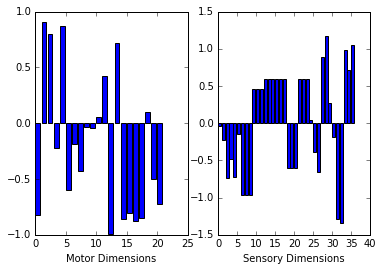

In [13]:
%matplotlib inline
fig, axes = plt.subplots(1,2)
m = environment3.random_motor()
s = environment3.update(m)

axes[0].bar(range(environment3.conf.m_ndims), m)
axes[0].set_xlabel('Motor Dimensions')
axes[1].bar(range(environment3.conf.s_ndims), s)
axes[1].set_xlabel('Sensory Dimensions')

We remind the reader that the sensory space is composed of the trajectories of each item: the arm, the tool and the 3 balls.  
There are 6 dimensions for each item (so 36D), representing the 2D position of the item at 3 time points along the movement duration.

Here is an example of movement to catch the blue ball (around 1 out of 10000 random motor parameters):

In [6]:
#m = [ 0.54984069,  0.02455233, -0.59603529, -0.6655813,   0.33923315,  0.22605509, 0.81641894, -0.26901228,  0.14363993, -0.71148838,  0.10504532,  0.58099297, -0.80227669,  0.48208766, -0.56107818, -0.68042166,  0.9648434,  -0.8760082, -0.19469749, -0.6141873,   0.11389673]
#s = environment3.update(m)
#display(HTML(environment3.plot(fig, ax)))
HTML('<video width="600" height="400" controls> <source src="./environment3.mp4" type="video/mp4"> </video>')

Let's try the Random Goal Babbling exploration strategy in this environment:

Iteration: 20000
Number of tool catch: 1606
Measure of exploration of tool: 26
Number of ball catch: 269
Measure of exploration of interesting ball: 6


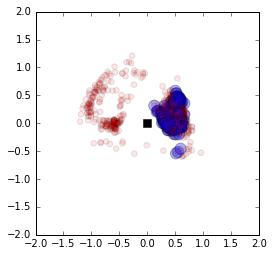

In [18]:
# Parameters to change:
iterations = 20000 # Number of iterations
sigma_explo_ratio = 0.05 # Exploration noise (standard deviation)

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb_t = []
explored_s_agb_o = []


# Initialization of the sensorimotor model
sm_model = SensorimotorModel.from_configuration(environment3.conf, 'nearest_neighbor', 'default')

# Bootstrap sensorimotor model: 1 random motor babbling
m = environment3.random_motor()
s = environment3.update(m)
sm_model.update(m, s)
    
for iteration in range(iterations):
    # Print number of iterations up to now:
    if (iteration+1) % 100 == 0:
        clear_output(wait=True)
        print "Iteration:", iteration+1
    # Compute the interest of modules
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        # Do random motor babbling while the ball has not been grasped, and then in 20% of the trials
        m = environment3.random_motor()
    else:
        # Sample a random goal in the sensory space:
        s_goal = rand_bounds(environment3.conf.s_bounds)[0]
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # Add exploration noise (of variance sigma) to experiment new motor parameters:
        m = normal(m, sigma_explo_ratio)
        
    s = environment3.update(m) # observe the sensory effect s (36D): the trajectory of all objects
    sm_model.update(m, s) # update sensorimotor model
        
    if abs(s[17] - 0.6) > 0.001:
        explored_s_agb_o += [[s[14], s[17]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,4:6]), 0.1, fc="b", alpha=0.3))
    if abs(s[11] - 0.46213203) > 0.001:
        explored_s_agb_t += [[s[8], s[11]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,2:4]), 0.05, fc="r", alpha=0.1))

#plt.savefig('explored_RGB_100000it')
        
print "Number of tool catch:", len(explored_s_agb_t)
print "Measure of exploration of tool:", int(compute_explo(array(explored_s_agb_t), array([-2., -2.]), array([2., 2.]), gs=grid_size))
print "Number of ball catch:", len(explored_s_agb_o)
print "Measure of exploration of interesting ball:", int(compute_explo(array(explored_s_agb_o), array([-2., -2.]), array([2., 2.]), gs=grid_size))

The red points are the points reached with the tool at the end of each movement that grabbed the tool, and the blue points are reached with the ball when it was caught.

The following image shows an example of exploration for 100000 iterations (10min) of Random Goal Babbling.  
The exploration of the ball was 11.

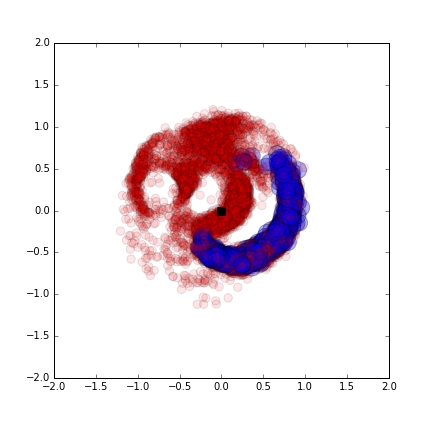

In [11]:
Image('./explored_RGB_100000it.png')

Here there are 36 sensory dimensions, and Goal Babbling chooses random goals in this space, where most of the space is unreachable (or uncontrollable: the random balls). This strategy thus fail to explore interesting parts of the sensory space, and only few cells are reached with the controllable ball.  

Active Goal Babbling can't directly help here in 36 dimensions because a discretization of this space would have way too much cells.  
Therefore, we need to change the representation of this space in order to discriminate the variables that are controllable from random variables, and to define smaller-dimensional but interesting sensory spaces.

-------------------------------
# VI. Active Model Babbling

Instead of learning a sensorimotor model that maps the motor space to the whole sensory space (mixing learnable and random variables), we define here Active Model Babbling as the parallel exploration of several sensorimotor models based on a measure of their progress.

As the 36D sensory space represents the trajectory of 6 objects in the environment (hand, tool, 4 balls), we define 6 sensory subspaces corresponding to the variables of those objects. For each of those objects, the agent learns a sensorimotor model that maps the motor space to the corresponding sensory subspace.  

The 6 sensorimotor mappings are learnt with the previously defined Goal Babbling strategy, choosing goals in the sensory subspace and trying to reach them given the current knowledge in the corresponding sensorimotor mapping.

For example, if at a given iteration the agent explores the mapping between the motor space and the sensory space of the hand, it learns to move the hand independently of the other objects. However, if the exploration of the trajectory of the hand produced a movement where the tool was caught, then the senrimotor mapping between the motor space and the sensory subspace of the tool is also updated. Exploring a sensory subspace can thus allow to make progress in the other subspaces.

At each iteration, a model (or sensory subspace) to explore is chosen (thus the name Model Babbling), and then a random goal is chosen in this sensory subspace. The agent now does 5 iterations with this goal: 4 adding gaussian exploration noise, and 1 without noise. This last iteration allows to reliably measure the progress made to reach the goal.

In our implementation of Active Model Babbling, at each iteration the agent chooses the model to explore in a probabilistic way: in 20% of the iterations the model is chosen randomly, and in the other iterations the model is chosen with a probability proportional to its learning progress.


Iteration: 20000


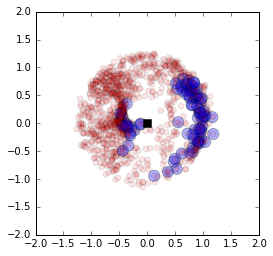

In [24]:
# Parameters to change:
iterations = 20000 # Number of iterations

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb_t = []
explored_s_agb_o = []
interests_evolution = []
n_explore = 4

def plot_s(s):
    global explored_s_agb_t, explored_s_agb_o
    if abs(s[17] - 0.6) > 0.001:
        explored_s_agb_o += [[s[14], s[17]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,4:6]), 0.1, fc="b", alpha=0.3))
    if abs(s[11] - 0.46213203) > 0.001:
        explored_s_agb_t += [[s[8], s[11]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,2:4]), 0.05, fc="r", alpha=0.1))
        

# Define motor and sensory spaces:
m_ndims = environment3.conf.m_ndims # number of motor parameters
m_space = range(m_ndims)
s_hand  = range(m_ndims, m_ndims+6)
s_tool  = range(m_ndims+6, m_ndims+12)
s_ball1 = range(m_ndims+12, m_ndims+18)
s_ball2 = range(m_ndims+18, m_ndims+24)
s_ball3 = range(m_ndims+24, m_ndims+30)
s_ball4 = range(m_ndims+30, m_ndims+36)

# Create the 6 learning modules:
learning_modules = {}
learning_modules['mod1'] = LearningModule("mod1", m_space, s_hand, environment3.conf)
learning_modules['mod2'] = LearningModule("mod2", m_space, s_tool, environment3.conf)
learning_modules['mod3'] = LearningModule("mod3", m_space, s_ball1, environment3.conf)
learning_modules['mod4'] = LearningModule("mod4", m_space, s_ball2, environment3.conf)
learning_modules['mod5'] = LearningModule("mod5", m_space, s_ball3, environment3.conf)
learning_modules['mod6'] = LearningModule("mod6", m_space, s_ball4, environment3.conf)


# Steps of (4 exploring and 1 exploiting iterations):
for step in range(iterations / (n_explore + 1)):
    # Print number of iterations up to now:
    if (step+1) % 20 == 0:
        clear_output(wait=True)
        print "Iteration:", (step+1) * (n_explore + 1)
    # Compute the interest of modules
    interests = [learning_modules[mid].interest() for mid in learning_modules.keys()]
    interests_evolution.append(interests)
    # Choose the babbling module (probabilities proportional to interests, with epsilon of random choice):
    babbling_module = learning_modules.values()[prop_choice(interests, eps=0.2)]
    # The babbling module picks a random goal in its sensory space and returns 4 noisy motor commands:
    m_list = babbling_module.produce(n=n_explore)
    for m in m_list:
        s = environment3.update(m) # execute this command and observe the corresponding sensory effect
        plot_s(s) # plot the observed sensory effect
        # Update each sensorimotor models:
        for mid in learning_modules.keys():
            learning_modules[mid].update_sm(m, learning_modules[mid].get_s(array(list(m) + list(s))))
    # Choose the best motor command to reach current goal (with no noise):
    m = babbling_module.infer(babbling_module.expl_dims, babbling_module.inf_dims, babbling_module.x, n=1, explore=False)    
    s = environment3.update(m) # execute this command and observe the corresponding sensory effect
    # Update the interest of the babbling module:
    babbling_module.update_im(m, babbling_module.get_s(array(list(m)+list(s))))
    # Update each sensorimotor models:
    for mid in learning_modules.keys():
        learning_modules[mid].update_sm(m, learning_modules[mid].get_s(array(list(m) + list(s))))
        

#plt.savefig('explored_AMB_100000it')

In [25]:
for mid in learning_modules.keys():
    print "Number of babbling steps for module", mid, ":", learning_modules[mid].im.n_points(), "{}%".format(int(100. * (n_explore + 1)*learning_modules[mid].im.n_points() / float(learning_modules[mid].sm.t)))
print
    
print "Number of tool catch:", len(explored_s_agb_t)
print "Measure of exploration of tool:", int(compute_explo(array(explored_s_agb_t), array([-2., -2.]), array([2., 2.]), gs=grid_size))
print "Number of ball catch:", len(explored_s_agb_o)
print "Measure of exploration of interesting ball:", int(compute_explo(array(explored_s_agb_o), array([-2., -2.]), array([2., 2.]), gs=grid_size))

Number of babbling steps for module mod1 : 1896 47%
Number of babbling steps for module mod2 : 1180 29%
Number of babbling steps for module mod3 : 393 9%
Number of babbling steps for module mod4 : 143 3%
Number of babbling steps for module mod5 : 202 5%
Number of babbling steps for module mod6 : 184 4%

Number of tool catch: 1193
Measure of exploration of tool: 39
Number of ball catch: 88
Measure of exploration of interesting ball: 17


Active Model Babbling has better explored the tool and object spaces than Random Goal Babbling.

In the following figure we plot the interest of each module along time steps in the previous run.

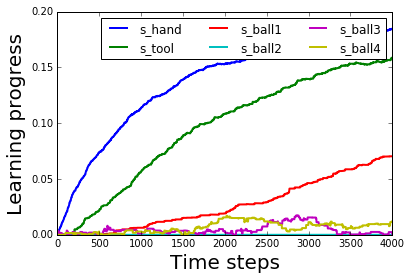

In [26]:
fig, ax = plt.subplots()
ax.plot(array(interests_evolution), lw=2)
ax.legend(["s_hand", "s_tool", "s_ball1", "s_ball2", "s_ball3", "s_ball4"], ncol=3)
ax.set_xlabel('Time steps', fontsize=20)
ax.set_ylabel('Learning progress', fontsize=20)
#plt.savefig('learning_progress_AMB_100000it')

The interest of the static ball (s_ball2) is always 0.  
The interest of random balls (s_ball3 and 4) is small.  
The interest of hand is high at the beginning and allows to explore movements of the hand and to discover the tool (no other motor babbling).

In the following images, the same results are shown for 100000 iterations / 20000 steps (10min).
The number of cells reached with the ball was 35.

In [15]:
display(HTML("<img style='width: 400px; margin: 0px; float: left; border: 1px solid black;' src='./learning_progress_AMB_100000it.png' /> <img style='width: 400px; margin: 0px; float: left; border: 1px solid black;' src='./explored_AMB_100000it.png' />"))

We finally show the exploration results with more trials of each condition.  
The 3 conditions are:the following:
* Random Motor Babbling
* Random Goal Babbling
* Active Model Babbling

We run 10 trials of each condition, and plot the exploration against iteration, with standard deviations.

In [46]:
trials = 10
iterations = 5000

def random_motor_babbling(iteration):
    explored_s = []
    res = []
    for iteration in range(iterations):
        m = environment3.random_motor()
        s = environment3.update(m)
        if (len(explored_s) == 0) or abs(s[17] - 0.6) > 0.001:
            explored_s += [s]
        if (iteration+1) % (iterations/10) == 0:
            res += [int(compute_explo(array(explored_s)[:,[14,17]], array([-2., -2.]), array([2., 2.]), gs=grid_size))]
    return res

def random_goal_babbling(iteration):
    explored_s = []
    res = []
    sigma_explo_ratio = 0.05
    sm_model = SensorimotorModel.from_configuration(environment3.conf, 'nearest_neighbor', 'default')
    m = environment3.random_motor()
    s = environment3.update(m)
    sm_model.update(m, s)
    for iteration in range(iterations):
        if (not sm_model.bootstrapped_s) or random() < 0.2:
            m = environment3.random_motor()
        else:
            s_goal = rand_bounds(environment3.conf.s_bounds)[0]
            m = sm_model.model.infer_order(tuple(s_goal))
            m = normal(m, sigma_explo_ratio)
        s = environment3.update(m) # observe the sensory effect s (36D): the trajectory of all objects
        sm_model.update(m, s) # update sensorimotor model
        if (len(explored_s) == 0) or abs(s[17] - 0.6) > 0.001:
            explored_s += [s]
        if (iteration+1) % (iterations/10) == 0:
            res += [int(compute_explo(array(explored_s)[:,[14,17]], array([-2., -2.]), array([2., 2.]), gs=grid_size))]
    return res

def active_model_babbling(iteration):
    explored_s = []
    res = []
    m_ndims = environment3.conf.m_ndims # number of motor parameters
    m_space = range(m_ndims)
    s_hand  = range(m_ndims, m_ndims+6)
    s_tool  = range(m_ndims+6, m_ndims+12)
    s_ball1 = range(m_ndims+12, m_ndims+18)
    s_ball2 = range(m_ndims+18, m_ndims+24)
    s_ball3 = range(m_ndims+24, m_ndims+30)
    s_ball4 = range(m_ndims+30, m_ndims+36)
    learning_modules = {}
    learning_modules['mod1'] = LearningModule("mod1", m_space, s_hand, environment3.conf)
    learning_modules['mod2'] = LearningModule("mod2", m_space, s_tool, environment3.conf)
    learning_modules['mod3'] = LearningModule("mod3", m_space, s_ball1, environment3.conf)
    learning_modules['mod4'] = LearningModule("mod4", m_space, s_ball2, environment3.conf)
    learning_modules['mod5'] = LearningModule("mod5", m_space, s_ball3, environment3.conf)
    learning_modules['mod6'] = LearningModule("mod6", m_space, s_ball4, environment3.conf)
    for step in range(iterations / (n_explore + 1)):
        interests = [learning_modules[mid].interest() for mid in learning_modules.keys()]
        interests_evolution.append(interests)
        babbling_module = learning_modules.values()[prop_choice(interests, eps=0.2)]
        m_list = babbling_module.produce(n=n_explore)
        for m in m_list:
            s = environment3.update(m) # execute this command and observe the corresponding sensory effect
            if (len(explored_s) == 0) or abs(s[17] - 0.6) > 0.001:
                explored_s += [s]
            for mid in learning_modules.keys():
                learning_modules[mid].update_sm(m, learning_modules[mid].get_s(array(list(m) + list(s))))
        m = babbling_module.infer(babbling_module.expl_dims, babbling_module.inf_dims, babbling_module.x, n=1, explore=False)    
        s = environment3.update(m) # execute this command and observe the corresponding sensory effect
        babbling_module.update_im(m, babbling_module.get_s(array(list(m)+list(s))))
        for mid in learning_modules.keys():
            learning_modules[mid].update_sm(m, learning_modules[mid].get_s(array(list(m) + list(s))))
        if (step+1) % ((iterations / (n_explore + 1))/10) == 0:
            res += [int(compute_explo(array(explored_s)[:,[14,17]], array([-2., -2.]), array([2., 2.]), gs=grid_size))]
    return res


print random_motor_babbling(iterations)
print random_goal_babbling(iterations)
print active_model_babbling(iterations)

rmb = []
rgb = []
amb = []

for trial in trials:
    rmb += [random_motor_babbling(iterations)]
    rgb += [random_goal_babbling(iterations)]
    amb += [active_model_babbling(iterations)]

[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 3, 3, 3, 3, 3, 3, 3, 3]
